# Applied Data Science Spring 2019

## Project 1 : What made you happy today?

This project is conducted by Qiaozhen Ma (qm2138)

## Summery

### Data preparation and basic analysis
Prepare data and count the number of words in happy moments.
### Topic modelling (LDA) and word cloud
Using topic modelling to find topics of happy moment;
Visualizing frequency of words to find important words.
### Entity extraction
Using other dataset in topic_dict to do a straighforward entity extraction of food and entertainment.
### Variate analysis
Compare happy moments between different groups.



### Data preparation and basic analysis

In [1]:
import pandas as pd
import nltk 
ps = nltk.stem.PorterStemmer()
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import string

from gensim import corpora, models
import gensim
### LDA

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
### word cloud

import seaborn as sns

In [2]:
happy=pd.read_csv('D:/python/rit-public-HappyDB-b9e529e/happydb/data/cleaned_hm.csv')
happy.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection


In [3]:
demographic = pd.read_csv('D:/python/rit-public-HappyDB-b9e529e/happydb/data/demographic.csv')
demographic.head(2)

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y


In [4]:
happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100535 entries, 0 to 100534
Data columns (total 9 columns):
hmid                     100535 non-null int64
wid                      100535 non-null int64
reflection_period        100535 non-null object
original_hm              100535 non-null object
cleaned_hm               100535 non-null object
modified                 100535 non-null bool
num_sentence             100535 non-null int64
ground_truth_category    14125 non-null object
predicted_category       100535 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 6.2+ MB


In [5]:
demographic.info()
#get dataset size and description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844 entries, 0 to 10843
Data columns (total 6 columns):
wid           10844 non-null int64
age           10809 non-null object
country       10771 non-null object
gender        10812 non-null object
marital       10787 non-null object
parenthood    10813 non-null object
dtypes: int64(1), object(5)
memory usage: 508.4+ KB


In [6]:
#Create additional column with length of cleaned_hm
happy['length'] = happy['cleaned_hm'].apply(lambda x: len(x.split()))
happy.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,length
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,14
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection,12


In [7]:
happy['length'].describe()

count    100535.000000
mean         18.298503
std          21.474146
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: length, dtype: float64

From the result above, it seems that most happy time are short sentences. And let's look at the longest sentence and the shortest sentences.

In [8]:
happy['cleaned_hm'][happy['length']==1179]

60804    My much awaited desired prolonged Velankanni t...
Name: cleaned_hm, dtype: object

In [9]:
happy['cleaned_hm'][happy['length']==2]

1100         Shooting guns.
4903              My kids. 
7646             dude, weed
12496        watching ncis.
14868        Donated blood.
22536        Doing laundry.
23330            I relaxed.
23419            It rained.
24137    Playing minecraft.
24697        I masturbated.
27499              I pooed.
29038            Waking up.
29269      planning dinner.
30031     Eating breakfast.
38163               Won 50$
43852         Getting laid.
45380       Going swimming!
50077      Drinking coffee.
51727     Cousin's Marriage
56505       Eating fajitas!
57083          I graduated!
59320     Conductor drives.
62786        Reading books.
63772          It's Friday.
70714     Stomouch swallon.
76322            I cuddled.
78121      Getting engaged.
80843          Sleeping in.
87166        I masturbated.
89361             I walked.
91093                I ran.
91412       Getting hugged.
94299           Worked out.
Name: cleaned_hm, dtype: object

### Topic modelling (LDA) and word cloud

In [10]:
stoplist = set(stopwords.words("english"))
def preprocess(text):
    text_punc = [char for char in text if char not in string.punctuation]
    text = ''.join(text_punc)      
    return [word for word in text.split() if (word.lower() not in stoplist) ]


In [11]:
happy['cleaned_hm'] = happy['cleaned_hm'].apply(preprocess)

In [12]:
def stem(text):
    text = ' '.join(ps.stem(word) for word in text)
    return[word for word in text.split()]

In [13]:
happy['cleaned_hm'] = happy['cleaned_hm'].apply(stem)

In [14]:
happy.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,length
0,27673,2053,24h,I went on a successful date with someone I fel...,"[went, success, date, someon, felt, sympathi, ...",True,1,NaN,affection,14
1,27674,2,24h,I was happy when my son got 90% marks in his e...,"[happi, son, got, 90, mark, examin]",True,1,NaN,affection,12


In [15]:
cleaned=happy['cleaned_hm'].tolist()

In [18]:
dictionary= corpora.Dictionary(cleaned)
corpus = [dictionary.doc2bow(text) for text in cleaned]

In [19]:
lda = gensim.models.ldamodel.LdaModel(corpus, num_topics = 5, id2word = dictionary, passes =20)

In [20]:
print(lda)

LdaModel(num_terms=20914, num_topics=5, decay=0.5, chunksize=2000)


In [21]:
print(lda.print_topics())

[(0, '0.054*"work" + 0.027*"got" + 0.023*"happi" + 0.019*"get" + 0.016*"abl" + 0.015*"today" + 0.013*"day" + 0.012*"job" + 0.012*"made" + 0.012*"receiv"'), (1, '0.051*"time" + 0.050*"friend" + 0.018*"went" + 0.015*"got" + 0.014*"old" + 0.014*"year" + 0.013*"long" + 0.013*"day" + 0.012*"talk" + 0.012*"month"'), (2, '0.016*"dog" + 0.013*"look" + 0.012*"car" + 0.012*"walk" + 0.011*"new" + 0.011*"ate" + 0.011*"lunch" + 0.010*"today" + 0.010*"got" + 0.010*"realli"'), (3, '0.031*"happi" + 0.025*"famili" + 0.023*"new" + 0.023*"dinner" + 0.022*"went" + 0.018*"day" + 0.017*"made" + 0.016*"home" + 0.016*"wife" + 0.016*"bought"'), (4, '0.032*"happi" + 0.025*"play" + 0.021*"watch" + 0.018*"game" + 0.018*"made" + 0.015*"event" + 0.015*"moment" + 0.015*"life" + 0.012*"new" + 0.011*"son"')]


Topic 1: work;
Topic 2: friend;
Topic 3: leisure;
Topic 4: family;
Topic 5: entertainment

In [22]:
nolist = ['happi', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going',
'getting', 'took', 'found', 'lot', 'realli', 'saw', 'see', 'month', 'week', 'day', 'yesterday',
'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without',
'yesteri', '2s', 'toand', 'ing', 'got', 'came', 'could', 'happiness', 'new', 'able', 'finally', 'like',
'old', 'years', 'many', '2', 'get', 'taj', 'nice', 'top', 'back']
def delete(text):
    return[word for word in text if (word.lower() not in nolist)]

In [23]:
happy['cleaned_hm']=happy['cleaned_hm'].apply(delete)

In [24]:
happy['cleaned_hm']=happy['cleaned_hm'].apply(', '.join)

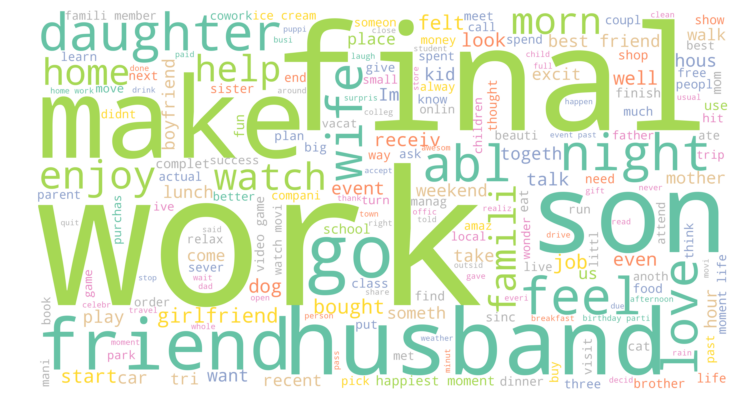

In [25]:
text = ' '.join(happy['cleaned_hm'].tolist())
wordcloud = WordCloud(background_color="white", height=2200, width=4000).generate(text)
plt.figure( figsize=(18,7) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")
plt.show()

### Entity extraction

#### Food

In [26]:
food=pd.read_csv('D:/python/rit-public-HappyDB-b9e529e/happydb/data/topic_dict/food-dict.csv', header = None)
food.columns = ['food']

In [27]:
food=food['food'].tolist()

In [28]:
food_dic = dict((x,0) for x in food)
tokens_hm = happy['cleaned_hm'].apply(lambda x: x.split())
for _, value in tokens_hm.iteritems():
    for word in value:
        if word in food:
            food_dic[word] += 1

In [29]:
sorted(food_dic.items(), key=lambda x: x[1],reverse=True)

[('dinner', 823),
 ('lunch', 463),
 ('food', 324),
 ('breakfast', 223),
 ('meal', 172),
 ('cream', 155),
 ('eat', 133),
 ('pizza', 120),
 ('drink', 104),
 ('cake', 88),
 ('dish', 81),
 ('beer', 80),
 ('cook', 79),
 ('dessert', 63),
 ('bar', 62),
 ('sandwich', 47),
 ('fish', 41),
 ('snack', 40),
 ('wine', 36),
 ('ate', 34),
 ('steak', 34),
 ('chicken', 33),
 ('burger', 31),
 ('donut', 31),
 ('tea', 30),
 ('bread', 27),
 ('egg', 27),
 ('fruit', 24),
 ('salad', 23),
 ('soup', 21),
 ('sushi', 19),
 ('eaten', 18),
 ('rice', 18),
 ('soda', 18),
 ('flavor', 17),
 ('picnic', 17),
 ('supper', 16),
 ('bbq', 15),
 ('burrito', 15),
 ('pie', 15),
 ('taco', 15),
 ('mango', 13),
 ('potato', 13),
 ('subway', 13),
 ('milk', 12),
 ('bake', 10),
 ('pasta', 10),
 ('bacon', 9),
 ('bite', 8),
 ('brunch', 8),
 ('cocktail', 8),
 ('yum', 8),
 ('bagel', 7),
 ('buffet', 7),
 ('butter', 7),
 ('cafe', 7),
 ('cookout', 7),
 ('drank', 7),
 ('pepper', 7),
 ('sugar', 7),
 ('syrup', 7),
 ('margarita', 6),
 ('meat', 6),

From the dictionary, we can find the most frequent six words related to food are dinner, lunch, food, breakfast, meal and cream. It is infered that people feel happier about dinner and the most enjoyable food is cream in the happyDB analysis.

#### Entertainment 

In [30]:
enter=pd.read_csv('D:/python/rit-public-HappyDB-b9e529e/happydb/data/topic_dict/entertainment-dict.csv', header = None)
enter.columns = ['enter']

In [31]:
enter=enter['enter'].tolist()

In [32]:
enter_dic = dict((x,0) for x in enter)

In [33]:
for _, value in tokens_hm.iteritems():
    for word in value:
        if word in enter:
            enter_dic[word] += 1

In [34]:
sorted(enter_dic.items(), key=lambda x: x[1],reverse=True)

[('show', 320),
 ('book', 210),
 ('read', 120),
 ('song', 119),
 ('music', 105),
 ('concert', 95),
 ('netflix', 87),
 ('tv', 76),
 ('video', 62),
 ('theater', 51),
 ('band', 48),
 ('album', 41),
 ('film', 34),
 ('radio', 27),
 ('artist', 23),
 ('cinema', 19),
 ('novel', 17),
 ('author', 14),
 ('lyric', 13),
 ('poem', 9),
 ('hulu', 9),
 ('singer', 6),
 ('writer', 5),
 ('musician', 5),
 ('tune', 3),
 ('manga', 3),
 ('broadcast', 2),
 ('fiction', 1),
 ('nintendo', 1),
 ('movie', 0),
 ('television', 0),
 ('videogame', 0),
 ('films', 0),
 ('movies', 0),
 ('shows', 0),
 ('books', 0),
 ('videogames', 0),
 ('video-game', 0),
 ('broadcasts', 0),
 ('broadcasting', 0),
 ('novels', 0),
 ('broadcasted', 0),
 ('aired', 0),
 ('airing', 0),
 ('short stories', 0),
 ('non-fiction', 0),
 ('airs', 0),
 ('episodes', 0),
 ('flick', 0),
 ('nonfiction', 0),
 ('episode', 0),
 ('flicks', 0),
 ('science fiction', 0),
 ('poems', 0),
 ('poetry', 0),
 ('t.v.', 0),
 ('youtube', 0),
 ('premiere', 0),
 ('reading', 0),

The first five frequent words are show, book, read , song and music. Since book and read has similar meaning to some extent, and song , music are related. In conclusion, the top three happiest entertainment are watching shows, reading books and listening to music.

# Variate analysis

In [35]:
happy = pd.merge(happy, demographic, on='wid')
happy.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,length,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,"success, date, someon, felt, sympathi, connect",True,1,NaN,affection,14,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,"play, game, fun, enjoy, mechan",True,1,NaN,leisure,16,35,USA,m,single,n


In [36]:
happy.loc[happy['predicted_category']=='achievement', 'predicted_category']=1
happy.loc[happy['predicted_category']=='affection', 'predicted_category']=2
happy.loc[happy['predicted_category']=='bonding', 'predicted_category']=3
happy.loc[happy['predicted_category']=='enjoy_the_moment', 'predicted_category']=4
happy.loc[happy['predicted_category']=='exercise', 'predicted_category']=5
happy.loc[happy['predicted_category']=='leisure', 'predicted_category']=6
happy.loc[happy['predicted_category']=='nature', 'predicted_category']=7
happy.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,length,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,"success, date, someon, felt, sympathi, connect",True,1,NaN,2,14,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,"play, game, fun, enjoy, mechan",True,1,NaN,6,16,35,USA,m,single,n


#### Marital status

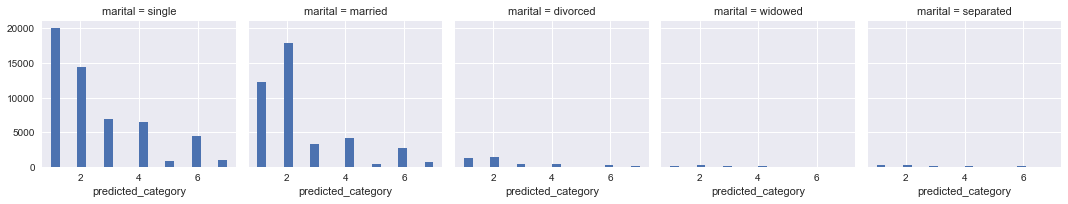

In [37]:
m = sns.FacetGrid(data=happy, col='marital')
m.map(plt.hist,'predicted_category', bins=20)
plt.show()

For most singles, their happy time is related to achievement while most married people's happy time is related to affection. It makes sense.

#### Gender

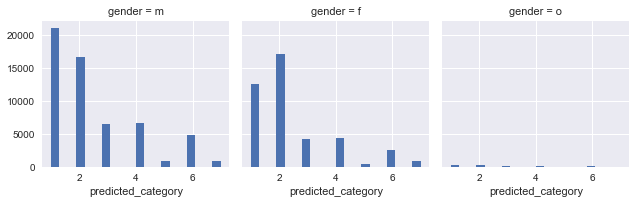

In [38]:
g = sns.FacetGrid(data=happy, col='gender')
g.map(plt.hist,'predicted_category', bins=20)
plt.show()

Male's happiness is more corelated to achievement than female's happiness is.

#### Reflection period

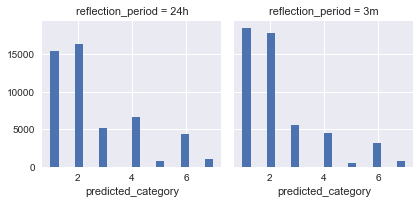

In [39]:
t = sns.FacetGrid(data=happy, col='reflection_period')
t.map(plt.hist,'predicted_category', bins=20)
plt.show()

It is infered that happiness which comes from achievement or bonding has a long term and that happiness which comes from affection of exercise has a relatively short term.

#### Country

In [40]:
happy.loc[happy['country']!='USA', 'country']=1
happy.loc[happy['country']=='USA', 'country']=0

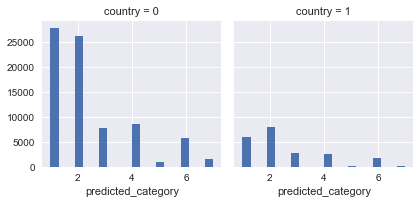

In [41]:
c = sns.FacetGrid(data=happy, col='country')
c.map(plt.hist,'predicted_category', bins=20)
plt.show()

It seems that American's happiness is more correlated to achivements than non-American's.

#### Parenthood

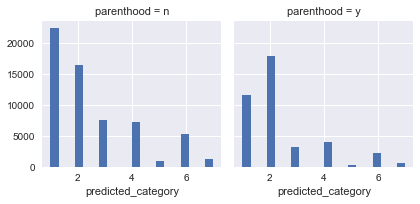

In [42]:
p = sns.FacetGrid(data=happy, col='parenthood')
p.map(plt.hist,'predicted_category', bins=20)
plt.show()

It shows that people who become parent enjoy more on affection than those who don't have child. And people who have not become parent will enjoy more on achievement.